# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
import re
import gc
import time
from contextlib import contextmanager

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import shap
shap.initjs()
import mlflow

from sklearn.pipeline import Pipeline
import joblib

In [2]:
# permet de cacher des warnings intempestifs provenant des différentes libraires (notamment mlflow) sans affecter le fonctionnement du notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
mlflow.set_experiment(experiment_name="Scoring Model")

2023/11/22 12:15:56 INFO mlflow.tracking.fluent: Experiment with name 'Scoring Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/Pierre/Documents/OpenClassrooms/Projet%207/backend_p7/mlruns/522536664981753469', creation_time=1700651756667, experiment_id='522536664981753469', last_update_time=1700651756667, lifecycle_stage='active', name='Scoring Model', tags={}>

In [4]:
# création d'un dossier pour récupérer les différentes images produites au cours du notebook
if not os.path.exists(os.path.join(os.getcwd(),'pics')):
    os.makedirs(os.path.join(os.getcwd(),'pics'))
    os.makedirs(os.path.join(os.getcwd()+'/pics','linear'))
    os.makedirs(os.path.join(os.getcwd()+'/pics','non_linear'))

# 2. Preprocessing functions

Je reprends une à une avec des annotations pour la compréhension les fonctions présentes dans le kernel disponible dans l'onglet `Ressources` du projet.

### Timer

In [5]:
# timer basique
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} {round(time.time() - t0,2)} s")

### Encodeur

In [6]:
# permet de one-hot-encoder les tableaux et de ressortir le tableau encodé + les nouvelles colonnes résultantes de l'encodage
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Chargement & Traitement _application_train_

In [7]:
# retourne le dataframe _train encodé + qqes colonnes annexes de pourcentages
# j'ai simplement modifié la fonction pour ne pas charger le jeu test et le garder lors de la vérification du data drift
def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../data/application_train.csv', nrows= num_rows)
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

### Chargement & Traitement _(bureau + bureau_balance)_

In [8]:
# retourne une agglomération encodée de bureau et bureau_balance
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # construction de la fusion des 2 tableaux
    # construction du dictionnaire en vue du groupby sur bureau_balance car plusieurs lignes pour un même crédit
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    # groupby sur les id crédit pour bureau_balance
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    # rename des colonnes pour plus de clarté
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    # jointure bureau(informations générales) + bureau_balance(informations de suivi moyennées)
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    # suppression de l'id nécessaire à la jointure
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # préparation en vue du groupby pour les colonnes numériques
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # préparation pour le groupby à venir pour les colonnes catégorielles
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    # aggrégation sur les individus (i.e. personnes portant le crédit) car plusieurs crédit par individu parfois
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    # rename des colonnes pour plus de clarté
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # création d'un dataframe avec les crédits actifs
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    # aggrég
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    # rename colonnes
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    # on le joint
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # même chose avec les crédits terminés
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    # on se retrouve au final avec un dataframe qui, pour chaque individu, retrace son historique de crédit,
    # général, terminé et actif (sachant que général = terminé+actif)
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

### Chargement & Traitement _previous_application_

In [9]:
# le traitement est à peu de chose près le même que précédemment pour bureau et bb
# on a un récap général + demandes refusées + demandes acceptées
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### Chargement & Traitement _POS_CASH_balance_

In [10]:
# traitement similaire avec différents critères pour qqes colonnes et un moyennage pour les colonnes catégorielles
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

### Chargement & Traitement _installements_payments_

In [11]:
# traitement similaire avec ajout de qqes colonnes, les jours de retard et restant passés en positif
# traitement récurrent pour le reste avec ajout de critères pour les colonnes numériques
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### Chargement & Traitement _credit_card_balance_

In [12]:
# même traitement basique
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

### Création du dataframe global

Je suis obligé de créer une distinction entre les données utilisées pour le modèle linéaire et le modèle non linéaire, ce dernier pouvant s'accomoder de valeurs manquantes, ce qui n'est pas le cas du premier.

In [13]:
def data_train(debug = False, linear=False):
    num_rows = 10000 if debug else None
    # construction df global
    df = application_train(num_rows)
    print("Train df shape:", df.shape)
    print("--------------")
    if not linear :
        with timer("Process bureau and bureau_balance"):
            bureau = bureau_and_balance(num_rows)
            print("Bureau df shape:", bureau.shape)
            df = df.join(bureau, how='left', on='SK_ID_CURR')
            del bureau
            gc.collect()
        with timer("Process previous_applications"):
            print("--------------")
            prev = previous_applications(num_rows)
            print("Previous applications df shape:", prev.shape)
            df = df.join(prev, how='left', on='SK_ID_CURR')
            del prev
            gc.collect()
        with timer("Process POS-CASH balance"):
            print("--------------")
            pos = pos_cash(num_rows)
            print("Pos-cash balance df shape:", pos.shape)
            df = df.join(pos, how='left', on='SK_ID_CURR')
            del pos
            gc.collect()
        with timer("Process installments payments"):
            print("--------------")
            ins = installments_payments(num_rows)
            print("Installments payments df shape:", ins.shape)
            df = df.join(ins, how='left', on='SK_ID_CURR')
            del ins
            gc.collect()
        with timer("Process credit card balance"):
            print("--------------")
            cc = credit_card_balance(num_rows)
            print("Credit card balance df shape:", cc.shape)
            df = df.join(cc, how='left', on='SK_ID_CURR')
            del cc
            gc.collect()
        print("--------------")
    # séparation
    if linear :
        df.dropna(how='any',inplace=True)
        labels = df['TARGET']
        df.drop(columns=['TARGET','SK_ID_CURR'],inplace=True)
        df = df.astype('float64')
        print("Individus avec valeurs manquantes supprimés")
    else :
        labels = df['TARGET']
        df.drop(columns=['TARGET','SK_ID_CURR'],inplace=True)
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # conflit entre LGBM et les caractères JSON
        df = df.astype('float64')
        print("Toutes les informations sont utilisées")
    print(f"**Taille du dataframe complet d'entrainement {df.shape}**")
    return df, labels

# 3. Entrainement du classifieur

## 3.1 Classifieur baseline

In [14]:
def baseline_classification(X, y):
    with timer("Temps d'entraînement du DummyClassifier :"):
        # split train/test
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=0,
                                                            stratify=y)
        # vérif dimensions
        print(f"X_train shape : {X_train.shape}")
        print(f"X_test shape : {X_test.shape}")
        print(f"y_train shape : {y_train.shape}")
        print(f"y_test shape : {y_test.shape}")
        print("--------------")
        # DummyClassifier
        dummy = DummyClassifier(strategy="constant", constant=1) # je fais ce choix de paramètre pour éxagérer une stratégie qui trouverait tous les individus avec l'étiquette 1
        dummy.fit(X_train,y_train)
        # scoring
        print(f"Precision(train) : {precision_score(y_train, dummy.predict(X_train))}")
        print(f"Recall(train) : {recall_score(y_train, dummy.predict(X_train))}")
        print(f"AUC(train) : {roc_auc_score(y_train, dummy.predict(X_train))}")
        print("--------------")
        print(f"Precision(test) : {precision_score(y_test, dummy.predict(X_test))}")
        print(f"Recall(test) : {recall_score(y_test, dummy.predict(X_test))}")
        print(f"AUC(test) : {roc_auc_score(y_test, dummy.predict(X_test))}")

In [15]:
# attribution données et étiquettes
df_linear, labels_linear = data_train(debug=False,linear=True)

Train samples: 307511
Train df shape: (307507, 247)
--------------
Individus avec valeurs manquantes supprimés
**Taille du dataframe complet d'entrainement (10745, 245)**


_Note : Le premier problème identifié d'utiliser une méthode linéaire est que l'on perd beaucoup d'individus depuis le fichier {application_train.csv} ainsi que toutes les informations contenues dans les autres fichiers car les modèles linéaires ne gèrent pas les valeurs manquantes. On pourrait réaliser une imputation des valeurs manquantes mais un nombre de 10,000+ individus reste satisfaisant pour construire notre modèle de prédiction. On prend tout de même la peine de vérifier qu'il reste assez d'individus de la classe minoritaire._

In [16]:
labels_linear.value_counts()

TARGET
0    10088
1      657
Name: count, dtype: int64

In [17]:
baseline_classification(df_linear, labels_linear)

X_train shape : (8596, 245)
X_test shape : (2149, 245)
y_train shape : (8596,)
y_test shape : (2149,)
--------------
Precision(train) : 0.06119125174499768
Recall(train) : 1.0
AUC(train) : 0.5
--------------
Precision(test) : 0.06095858538855282
Recall(test) : 1.0
AUC(test) : 0.5
Temps d'entraînement du DummyClassifier : 0.04 s


Notre dataset étant très déséquilibré (càd très peu d'individus considérés comme mauvais payeur), on observe logiquement en utilisant la strategy _"constant"_ que la sensibilité (recall) obtenue sur le jeu test est excessivement bonne si on donne l'étiquette 1 à tous les individus et qu'à contrario c'est la précision qui s'en retrouve très fortement impactée. C'est pour cela que l'on utilisera principalement le score AUC (Area Under Curve) qui est plus indiqué dans un cas de déséquilibre de classe. On gardera tout de même les deux métriques précédentes qui combinées permettent une première lecture de performance.
<br>
<br> Dans le cas où l'on assigne l'étiquette 1 (mauvais payeur) à tous les individus, on obtient alors une sensibilité parfaite (puisque tous les "True Positives" sont libellés en tant que tels) mais une précision catastrophique (puisque quasiment tous les individus se retrouve à être des "False Positives")
<br>
<br> _Note : Le résultat est très sensiblement le même avec le jeu de données qui sera utilisé pour la méthode non linéaire. Je garde donc les mêmes scores baseline en guise de limite basse._

## 3.2 Classifieur linéaire

In [18]:
def linear_classification(X, y):
    with timer("Temps d'entraînement du modèle linéaire :"):
        # mlflow tracking
        mlflow.sklearn.autolog()
        # split train/test
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=0,
                                                            stratify=y)
        # hyperparamètres
        param_grid = {'penalty' : ['l1','l2'], 
                      'C': np.logspace(-2,1,4)}
        # initialisation
        log_reg = LogisticRegression(dual=False,
                                     tol=0.001,
                                     class_weight="balanced",
                                     random_state=0,
                                     solver='liblinear',
                                     max_iter=100,
                                     multi_class='ovr',
                                     verbose=0)
        # affichage du traitement appliqué au déséqulibre de classe
        print(f"Voici les poids associés aux deux différentes classes : {dict(enumerate(X_train.shape[0] / (2 * np.bincount(y_train))))}")
        # incorporation à gridsearchcv
        gscv = GridSearchCV(log_reg,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            verbose=2)
        # fit
        with mlflow.start_run(run_name="Linear Regression") as run:
            gscv.fit(X_train, y_train)
        # récap
        best_params = gscv.best_params_
        best_score = gscv.best_score_
        # scoring
        y_pred_train = gscv.predict(X_train)
        y_pred_test = gscv.predict(X_test)
        print("Les meilleurs hyperparamètres obtenus sont :", best_params)
        print("Le meilleur score (AUC) est :", best_score)
        print("----- train -----")
        print(f"Precision : {precision_score(y_train, y_pred_train)}")
        print(f"Recall : {recall_score(y_train, y_pred_train)}")
        print(f"AUC : {roc_auc_score(y_train, y_pred_train)}")
        print("----- test -----")
        print(f"Precision : {precision_score(y_test, y_pred_test)}")
        print(f"Recall : {recall_score(y_test, y_pred_test)}")
        print(f"AUC : {roc_auc_score(y_test, y_pred_test)}")
        mlflow.sklearn.autolog(disable=True)
        # tracé de la feature importance
        best_log_reg = LogisticRegression(**best_params,
                                          dual=False,
                                          tol=0.001,
                                          class_weight='balanced',
                                          random_state=0,
                                          solver='liblinear',
                                          max_iter=100,
                                          multi_class='ovr',
                                          verbose=0)
        best_log_reg.fit(X, y) # on entraîne sur toutes les données maintenant qu'on a les meilleurs paramètres
        coefs = np.abs(best_log_reg.coef_[0]) # je prends la valeur absolue pour faciliter la comparaison
        idx_20 = np.argsort(coefs)[-20:][::-1] # je récupère les 20 coefs les plus importants (dont j'inverse l'ordre)
        plt.figure(figsize=(10,10))
        sns.barplot(x=coefs[idx_20],y=X.columns[idx_20])
        plt.xlabel('Valeur absolue du coefficient')
        plt.ylabel('Coefficient')
        plt.title('20 premiers coefficients de régression logistique')
        plt.tight_layout()
        plt.savefig('pics/linear/feature_importance_linear.png')
        plt.show()
        # return
        return best_params

Voici les poids associés aux deux différentes classes : {0: 0.5325898389095415, 1: 8.171102661596958}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l1; total time=   1.1s
[CV] END .................................C=0.01, penalty=l1; total time=   1.0s
[CV] END .................................C=0.01, penalty=l1; total time=   1.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.9s
[CV] END .................................C=0.01, penalty=l1; total time=   0.9s
[CV] END .................................C=0.01, penalty=l2; total time=   0.5s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.3s
[CV] END .................................C=0.01, penalty=l2; total time=   0.4s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END ...................

2023/11/22 12:17:20 INFO mlflow.sklearn.utils: Logging the 5 best runs, 3 runs will be omitted.


Les meilleurs hyperparamètres obtenus sont : {'C': 0.1, 'penalty': 'l1'}
Le meilleur score (AUC) est : 0.7399120120330753
----- train -----
Precision : 0.13659605551497445
Recall : 0.7110266159695817
AUC : 0.709044906497802
----- test -----
Precision : 0.13088235294117648
Recall : 0.6793893129770993
AUC : 0.6932625454875586


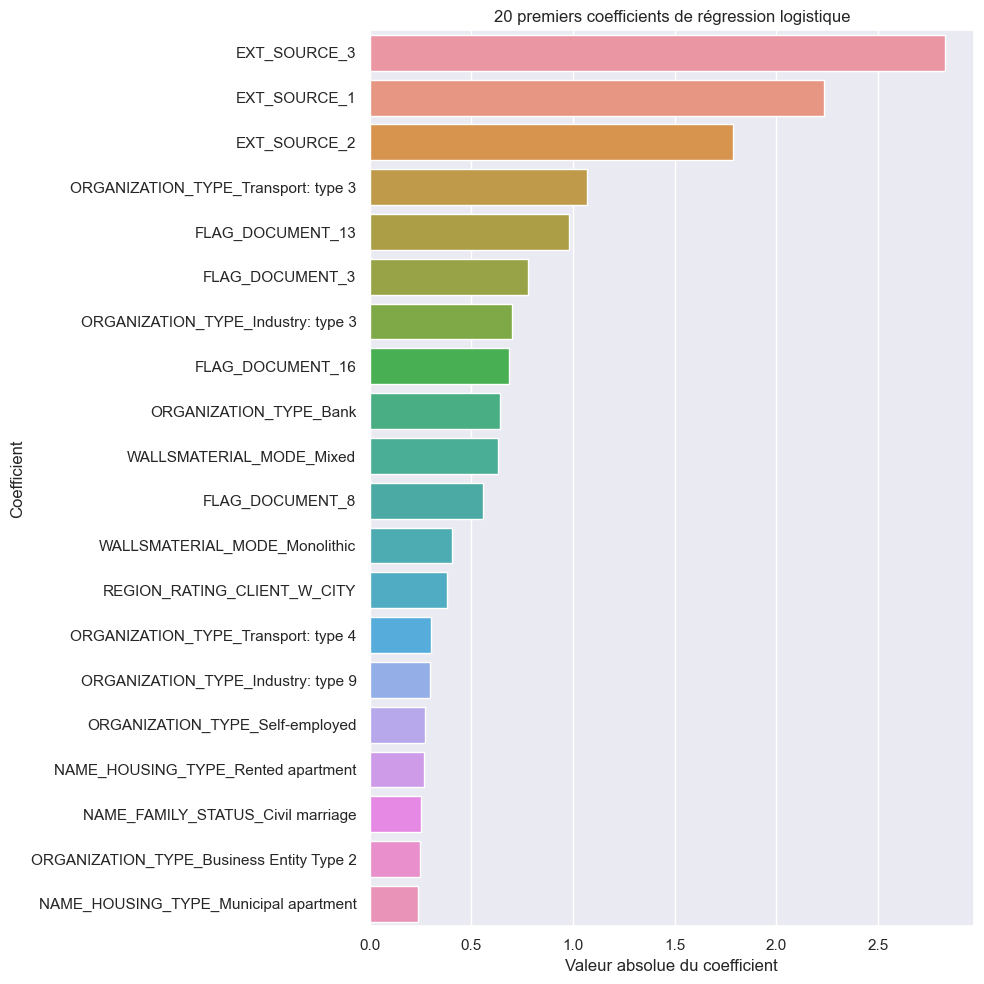

Temps d'entraînement du modèle linéaire : 84.42 s


In [19]:
params_linear = linear_classification(df_linear,labels_linear)

Le résultat de la classification linéaire est un bien meilleur résultat que la classification baseline ce qui est encourageant.
<br> Ensuite, le score AUC du jeu train et du jeu test sont très proches ce qui veut dire que notre modèle n'effectue pas d'overfitting et généralise aussi bien qu'il le peut.

In [20]:
# sauvegarde des paramètres dans un csv
df_params_linear = pd.DataFrame([params_linear])
df_params_linear.to_csv('params_linear.csv')

### Explicabilité globale et locale

Pour démontrer l'explicabilité globale et locale de notre modèle de machine learning et ainsi éviter l'effet "Black Box", nous utiliserons la librairie _SHAP_.

In [21]:
def shap_plot_linear(X, y, params, local=False, method='average'):
    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    # instanciation shap
    model = LogisticRegression(**params,
                               dual=False,
                               tol=0.001,
                               class_weight="balanced",
                               random_state=0,
                               solver='liblinear',
                               max_iter=100,
                               multi_class='ovr',
                               verbose=0)
    
    model.fit(X_train, y_train)
    explainer = shap.Explainer(model, X_train, features_names=model.feature_names_in_)
    shap_values = explainer(X_test)
    # plot
    # les indexes choisis ne sont pas des nombres magiques, il s'agit d'individus se trouvant à la fois dans le jeu test de la partie linéaire et non linéaire. Ils représentent également des cas faciles à expliquer
    # je les ai choisi hors de ce notebook pour ne pas l'alourdir 
    if local :
        print("Témoin positif (mauvais payeur)")
        shap.plots.waterfall(shap_values[519][:, 0], max_display=10, show=False)
        plt.title('Cheminement de décision : témoin positif')
        plt.savefig('pics/linear/waterfall_positive_linear.png', bbox_inches='tight')
        plt.show()
        print("----------------------")
        print("Témoin négatif (bon payeur)")
        shap.plots.waterfall(shap_values[166][:, 0], max_display=10, show=False)
        plt.title('Cheminement de décision : témoin négatif')
        plt.savefig('pics/linear/waterfall_negative_linear.png', bbox_inches='tight')
        plt.show()
    else :
        if method == 'absolute':
            shap.plots.beeswarm(shap_values, max_display=15, order=shap_values.abs.max(0), plot_size=(7,10), show=False)
            plt.title('Impact Absolu (linéaire)')
            plt.savefig('pics/linear/shap_importance_global_absolute_linear.png', bbox_inches='tight')
            plt.show()
        else :
            shap.plots.beeswarm(shap_values, max_display=15, plot_size=(7,10), show=False)
            plt.title('Impact Moyen (linéaire)')
            plt.savefig('pics/linear/shap_importance_global_average_linear.png', bbox_inches='tight')
            plt.show()        
    return None

#### Globale

Nous avons déjà une première idée de la feature importance concernant l'explicabilité globale de notre modèle linéaire via les coefficients de régression logistique mais ces derniers sont sensibles aux ordres de grandeur des données d'entrée et peuvent ne pas toujours représenter la réalité (comme expliqué dans [cet exemple](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#Examining-the-model-coefficients) de la documentation SHAP). Il est maintenant possible de venir confronter ce premier résultat à celui obtenu avec la librairie SHAP.

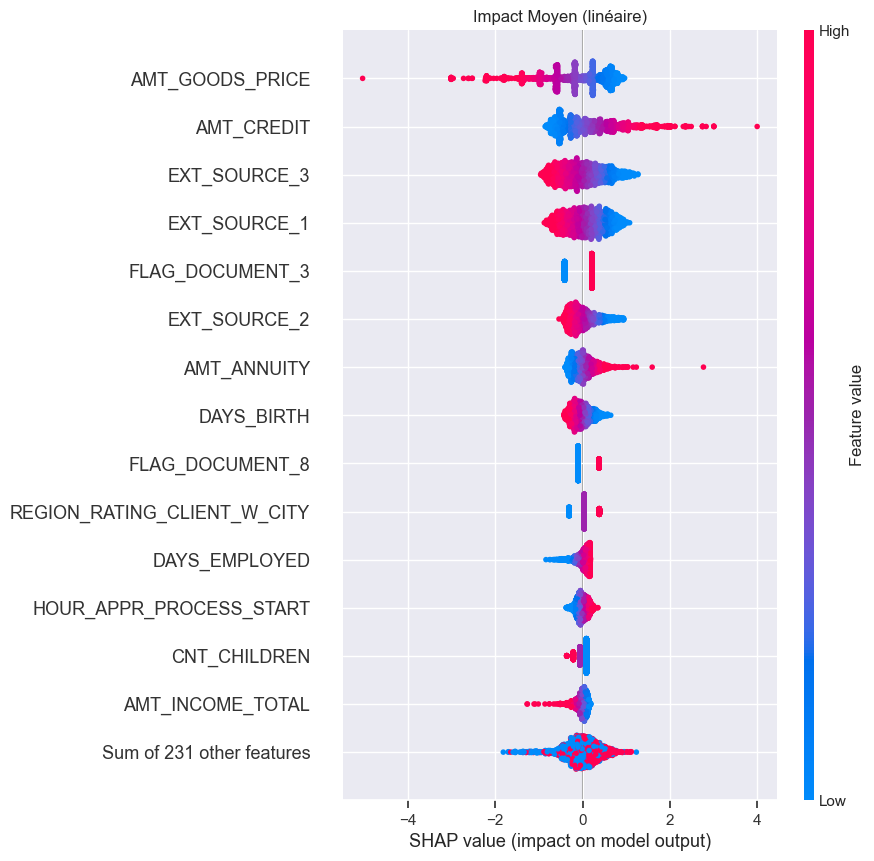

In [22]:
shap_plot_linear(df_linear, labels_linear, params_linear)

Ce graphique nous montre les variables avec le plus d'impact sur l'attribution d'une étiquette de manière générale (de haut en bas). On retrouve dans les têtes de série les variables <font color=yellow> _'EXT_SOURCE_1/2/3'_ </font> que l'on retrouvaient déjà en haut du graphique avec les coefficients de régression linéaire. De manière compréhensible on trouve également les variables <font color=yellow> _'AMT_GOODS_PRICE'_ </font> et <font color=yellow> _'AMT_CREDIT'_ </font> qui reflètent le montant du/des bien(s) voulu(s) par le client et le montant du crédit. On termine en notant également la présence de quelques variables comme l'âge, le temps passé dans le monde du travail ou encore évidement le salaire.
<br>
A noter que ce graphique présente les variables avec le plus d'impact global et non pas les variables avec les impacts les plus élevés en terme de valeur absolue. Mais la librairie _SHAP_ nous permet également cette possibilité et l'on retrouve beaucoup de similitude.

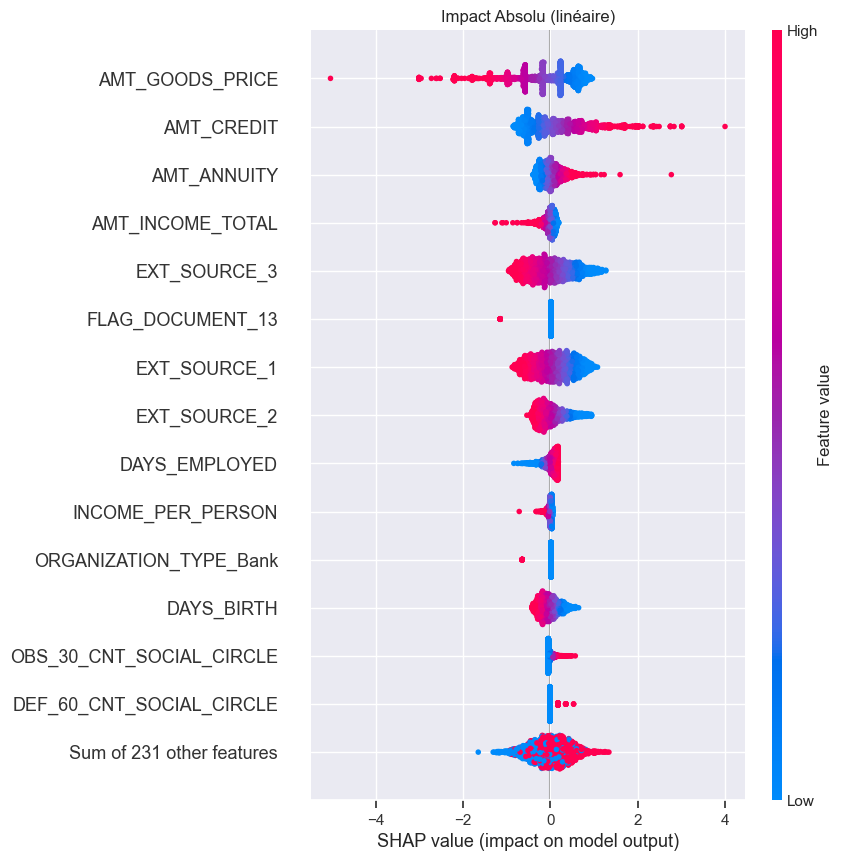

In [23]:
shap_plot_linear(df_linear, labels_linear, params_linear, method='absolute')

#### Locale

D'une façon analogue à ce que l'on vient de voir, il est possible de regarder de plus près comment se passe la prise de décision pour un individu précis. Regardons par exemple comment chaque variable influence le résultat final en prenant deux témoins diamétralement opposés respectivement labellés **positif** et **négatif**.

Témoin positif (mauvais payeur)


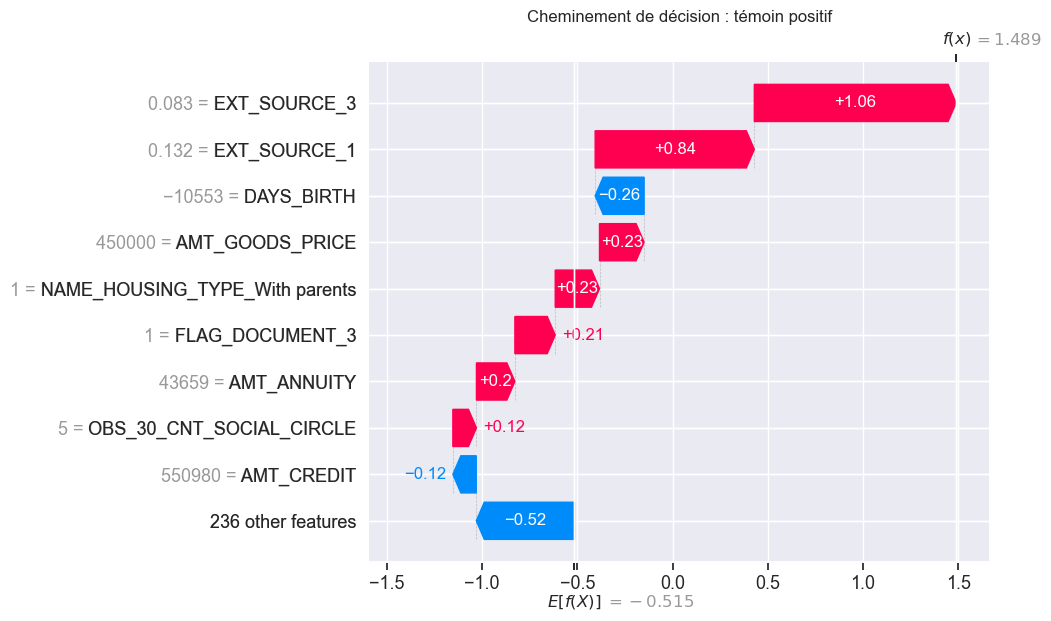

----------------------
Témoin négatif (bon payeur)


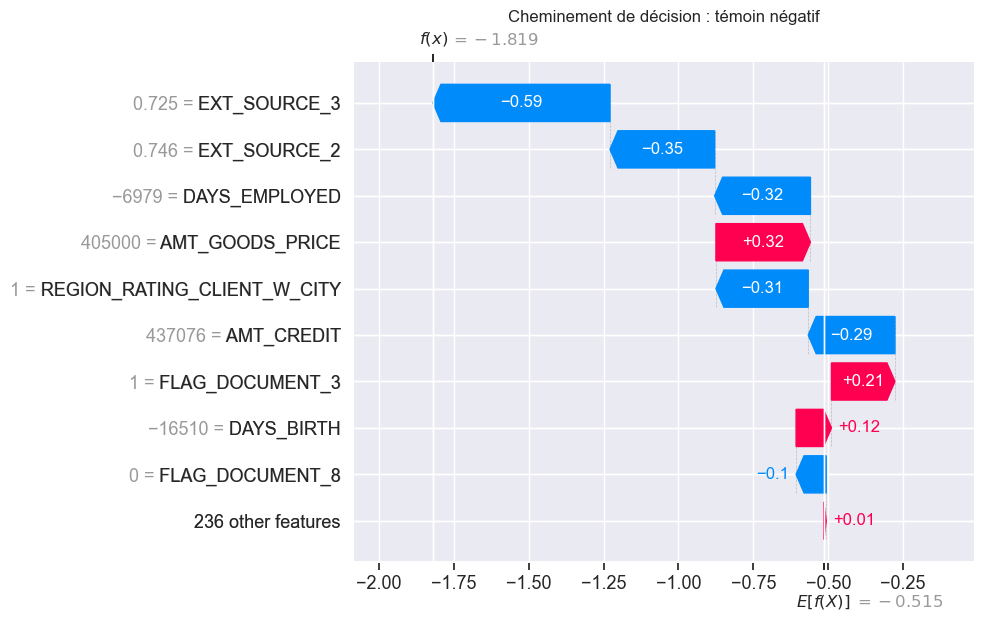

In [24]:
shap_plot_linear(df_linear, labels_linear, params_linear, local=True)

Il apparait ici de manière claire le cheminement de l'algorithme permettant de mener à une décision dans les deux cas. 
- **Cas du témoin positif**
<br> Deux variables de notation ont réussi à elles seules ou presque à décider de l'attribution d'étiquette.
- **Cas du témoin négatif**
<br> De manière opposée à l'individu témoin précédent, celui ci est poussé dans la bonne direction grâce à deux de ses notes ainsi qu'à son temps passé avec un emploi et sa situation géographique.

On voit bien que comme annoncé par les précédents graphiques, les notations attribuées aux individus jouent un rôle majeur.
<br>
<br> _Note : les deux cheminements juste au dessus sont très simples à comprendre mais en regardant d'autres exemples, il peut parfois être un peu plus confus de suivre la logique du modèle._

### Recherche du seuil idéal

Le seuil pour l'attribution de la classe est 0.5 par défaut. Maintenant que l'on a un modèle fité à nos données, on peut, avec les probabilités attribuées à chaque individu, faire évoluer ce seuil et déterminer sa valeur optimale. Pour cela, on partira du principe que le coût d'un faux négatif est 10 fois supérieur à celui d'un faux positif. L'équation de coût est donc la suivante :
* $Cost = (1 * nombreFauxPositifs) + (10 * nombreFauxNégatifs)$

L'objectif est ici de trouver quelle valeur de seuil minimise cette fonction.

In [25]:
def seuil_optimal_linear(X, y, params):
    model = LogisticRegression(**params,
                               dual=False,
                               tol=0.001,
                               class_weight="balanced",
                               random_state=0,
                               solver='liblinear',
                               max_iter=100,
                               multi_class='ovr',
                               verbose=0)
    # prédiction
    y_pred = model.fit(X, y).predict_proba(X)[:,1]
    # calcul
    best_cost = float('inf')
    cost_list=[]
    pic_name = 'pics/linear/cost_fct_threshold_linear.png'
    for seuil in np.arange(0,1.01,0.01):
        pred = pd.Series(np.where(y_pred >= seuil, 1, 0)) # création d'un vecteur d'attribution de classe en fonction du seuil et du vecteur 
        tmp = pd.concat([y.reset_index(drop=True),pred], ignore_index=True, axis=1)
        fp = tmp.loc[tmp[0]==0].loc[tmp[1]==1] # comptage False Positives
        fn = tmp.loc[tmp[0]==1].loc[tmp[1]==0] # comptage False Negatives
        cost = 1*len(fp) + 10*len(fn) # fonction coût
        cost_list.append(cost)
        if cost <= best_cost:
            best_cost = cost
            best_seuil = seuil
        
    print(f"Le coût le plus bas est {best_cost} (coût unitaire symbolique) et il est atteint pour un seuil à {best_seuil}")
    # plot
    plt.figure(figsize=(8,8))
    sns.lineplot(x=np.arange(0,1.01,0.01), y=cost_list)
    plt.xlabel('Valeur de seuil')
    plt.ylabel('Coût')
    plt.title("Evolution du coût en fonction du seuil d'appartenance à la classe 1")
    plt.tight_layout()
    plt.savefig(pic_name)
    plt.show()

Le coût le plus bas est 4634 (coût unitaire symbolique) et il est atteint pour un seuil à 0.63


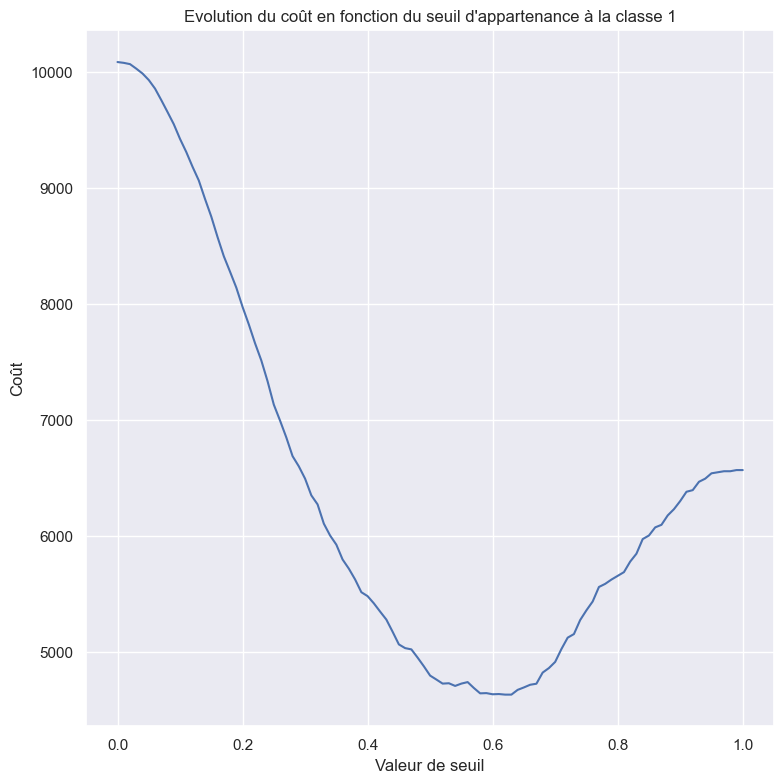

In [26]:
seuil_optimal_linear(df_linear, labels_linear, params_linear)

Le seuil optimal finalement trouvé pour départager un mauvais d'un bon client (en partant du principe qu'un faux négatif coûte 10 fois plus cher qu'un faux positif) est 0.63.

## 3.3 Classifieur non linéaire

In [27]:
# attribution données et étiquettes
df_nonlinear, labels_nonlinear = data_train(debug=False,linear=False)

Train samples: 307511
Train df shape: (307507, 247)
--------------
Bureau df shape: (305811, 116)
Process bureau and bureau_balance 21.76 s
--------------
Previous applications df shape: (338857, 249)
Process previous_applications 25.61 s
--------------
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance 13.88 s
--------------
Installments payments df shape: (339587, 26)
Process installments payments 30.76 s
--------------
Credit card balance df shape: (103558, 141)
Process credit card balance 13.95 s
--------------
Toutes les informations sont utilisées
**Taille du dataframe complet d'entrainement (307507, 795)**


In [28]:
def nonlinear_classification(X, y):
    with timer("Temps d'entraînement du modèle non linéaire :"):
        # mlflow tracking
        mlflow.sklearn.autolog()
        # split train/test
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=0,
                                                            stratify=y)
        # hyperparamètres
        param_grid = {'n_estimators' : [100,200],
                      'num_leaves' : [30,35],
                      'max_depth' : [-1]}
        # initialisation
        lgbmc = LGBMClassifier(objective='binary',
                              is_unbalance=True,
                              random_state=0,
                              verbose=0,
                              force_col_wise=True)
        # affichage du traitement appliqué au déséqulibre de classe
        print(f"Voici les poids associés aux deux différentes classes : {dict(enumerate(X_train.shape[0] / (2 * np.bincount(y_train))))}")
        # incorporation à gridsearchcv
        gscv = GridSearchCV(lgbmc,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            verbose=2)
        # fit
        with mlflow.start_run(run_name="Non Linear Regression"):
            gscv.fit(X_train, y_train)
        # récap
        best_params = gscv.best_params_
        best_score = gscv.best_score_
        # scoring
        y_pred_train = gscv.predict(X_train)
        y_pred_test = gscv.predict(X_test)
        print("Les meilleurs hyperparamètres obtenus sont :", best_params)
        print("Le meilleur score (AUC) est :", best_score)
        print("----- train -----")
        print(f"Precision : {precision_score(y_train, y_pred_train)}")
        print(f"Recall : {recall_score(y_train, y_pred_train)}")
        print(f"AUC : {roc_auc_score(y_train, y_pred_train)}")
        print("----- test -----")
        print(f"Precision : {precision_score(y_test, y_pred_test)}")
        print(f"Recall : {recall_score(y_test, y_pred_test)}")
        print(f"AUC : {roc_auc_score(y_test, y_pred_test)}")
        mlflow.sklearn.autolog(disable=True)
        # tracé de la feature importance
        best_lgbm = LGBMClassifier(**best_params,
                                   objective='binary',
                                   is_unbalance=True,
                                   random_state=0,
                                   verbose=0,
                                   force_col_wise=True)
        best_lgbm.fit(X, y)
        coefs = np.abs(best_lgbm.feature_importances_)
        idx_20 = np.argsort(coefs)[-20:][::-1]
        plt.figure(figsize=(10,10))
        sns.barplot(x=coefs[idx_20],y=X.columns[idx_20])
        plt.xlabel('Valeur absolue du coefficient')
        plt.ylabel('Coefficient')
        plt.title('20 premiers coefficients de classification avec LightGBM')
        plt.tight_layout()
        plt.savefig('pics/non_linear/feature_importance_nonlinear.png')
        plt.show()
        
        return best_params

Voici les poids associés aux deux différentes classes : {0: 0.5439098808286719, 1: 6.193479355488419}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=30; total time=  18.7s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=30; total time=  17.8s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=30; total time=  18.0s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=30; total time=  17.6s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=30; total time=  18.1s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=35; total time=  18.5s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=35; total time=  20.1s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=35; total time=  19.0s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=35; total time=  19.7s
[CV] END ......max_depth=-1, n_estimators=100, num_leaves=35; total time=  20.8s
[CV] END ......max_depth=-1,

2023/11/22 12:28:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Les meilleurs hyperparamètres obtenus sont : {'max_depth': -1, 'n_estimators': 100, 'num_leaves': 30}
Le meilleur score (AUC) est : 0.7818026657539565
----- train -----
Precision : 0.20311174724342662
Recall : 0.7717019133937563
AUC : 0.7529052802503505
----- test -----
Precision : 0.1842816991037811
Recall : 0.6998992950654582
AUC : 0.7139148384696378


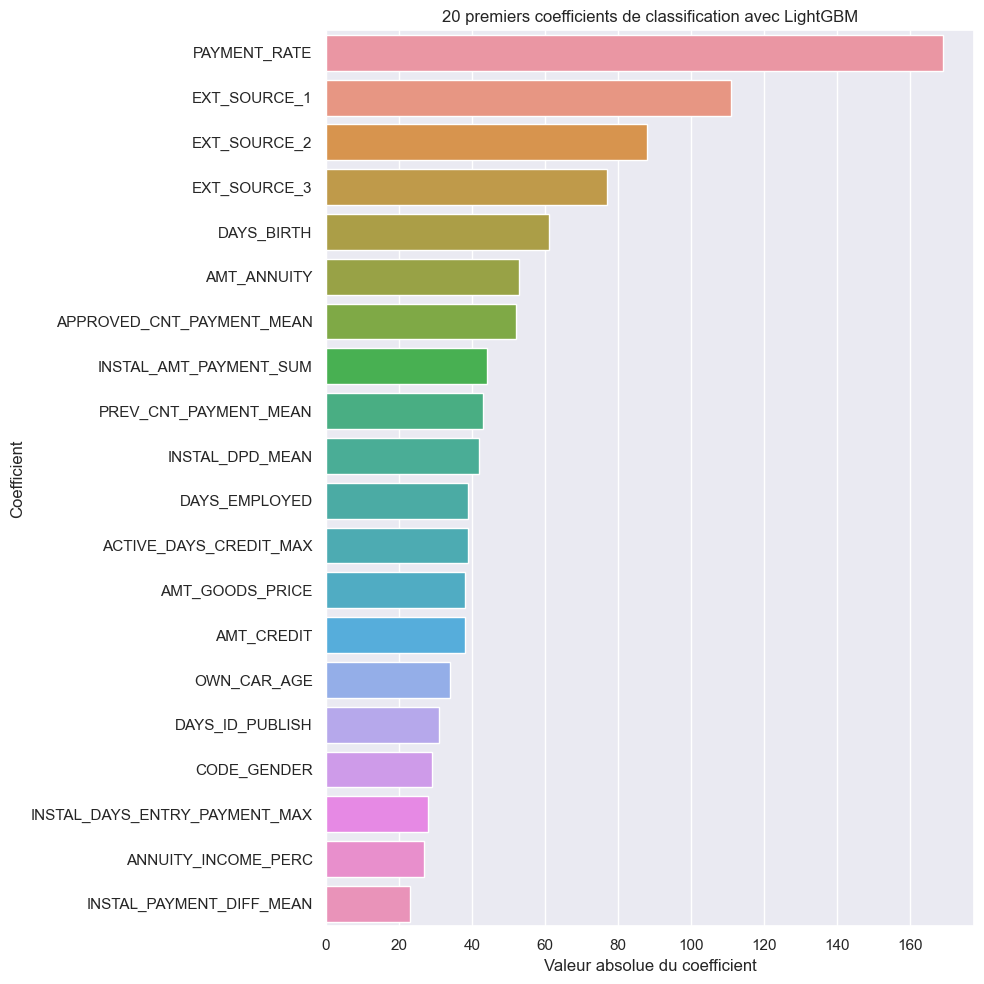

Temps d'entraînement du modèle non linéaire : 600.52 s


In [29]:
params_nonlinear = nonlinear_classification(df_nonlinear, labels_nonlinear)

Le résultat de la classification via LGBM est légèrement meilleur que le modèle avec la régression logistique et utilise également les données provenant des autres fichiers csv (quand il y en a).

In [30]:
# sauvegarde des paramètres dans un csv
df_params_nonlinear = pd.DataFrame([params_nonlinear])
df_params_nonlinear.to_csv('params_nonlinear.csv')

### Explicabilité globale et locale

In [31]:
def shap_plot_nonlinear(X, y, params):
    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    # instanciation shap
    model = LGBMClassifier(**params,
                           objective='binary',
                           is_unbalance=True,
                           random_state=0,
                           verbose=0,
                           force_col_wise=True)
    
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model, X_train, features_names=model.feature_name_)
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    # plot
    print('###############')
    print('##  GLOBALE  ##')
    print('###############')
    shap.summary_plot(shap_values, feature_names=X.columns.tolist(), max_display=15, plot_size=(10,10), show=False)
    plt.title('Impact Moyen (non linéaire)')
    plt.savefig('pics/non_linear/shap_importance_global_average_nonlinear.png', bbox_inches='tight')
    plt.show() 
    print('##############')
    print('##  LOCALE  ##')
    print('##############\n')
    print("Témoin positif (mauvais payeur)")
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[42417], feature_names=X.columns.tolist(), show=False)
    plt.title('Cheminement de décision : témoin positif')
    plt.savefig('pics/non_linear/waterfall_positive_nonlinear.png', bbox_inches='tight')
    plt.show()
    print("----------------------")
    print("Témoin négatif (bon payeur)")
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[44583], feature_names=X.columns.tolist(), show=False)
    plt.title('Cheminement de décision : témoin négatif')
    plt.savefig('pics/non_linear/waterfall_negative_nonlinear.png', bbox_inches='tight')
    plt.show()        
    return None

100%|===================| 61444/61502 [05:41<00:00]        

###############
##  GLOBALE  ##
###############


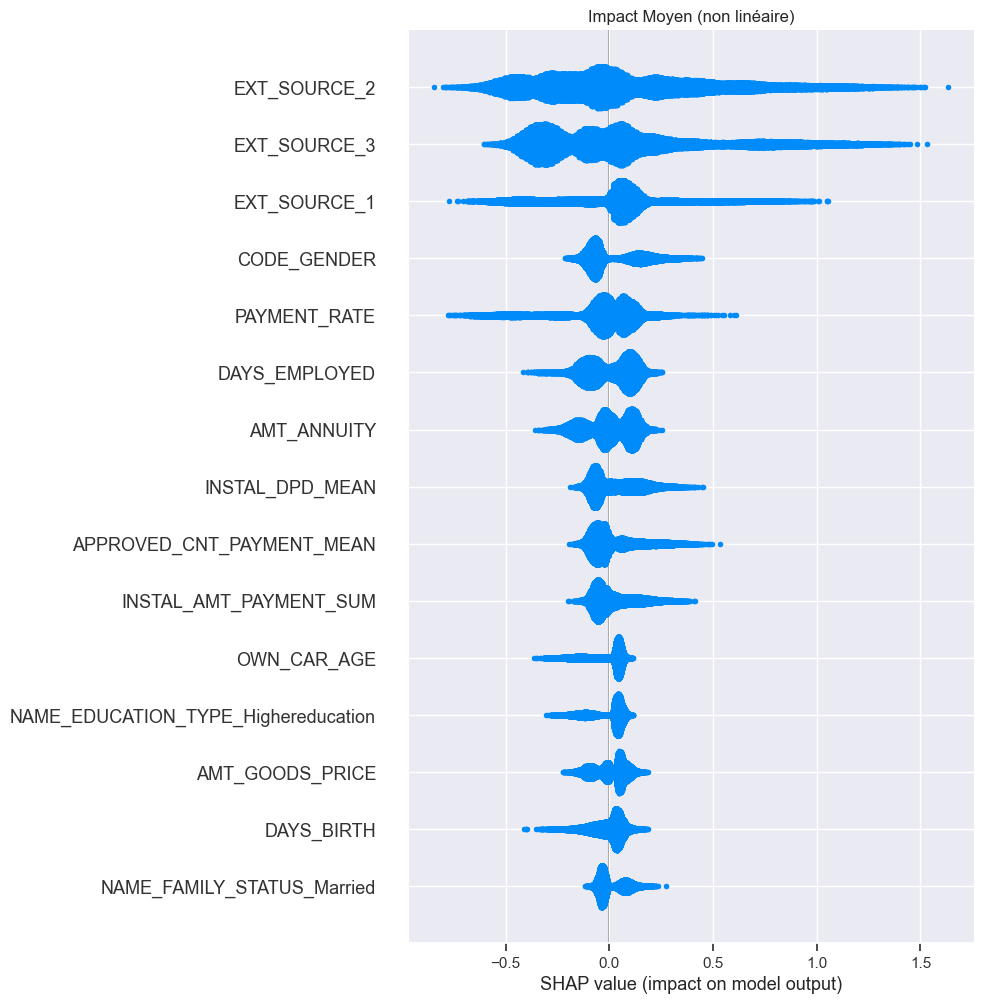

##############
##  LOCALE  ##
##############

Témoin positif (mauvais payeur)


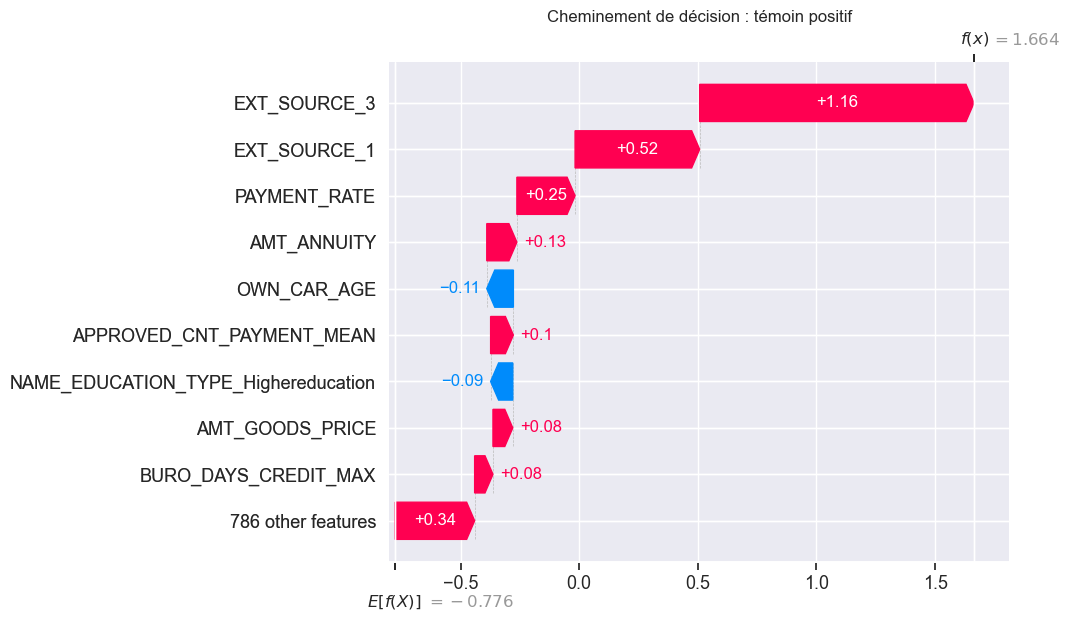

----------------------
Témoin négatif (bon payeur)


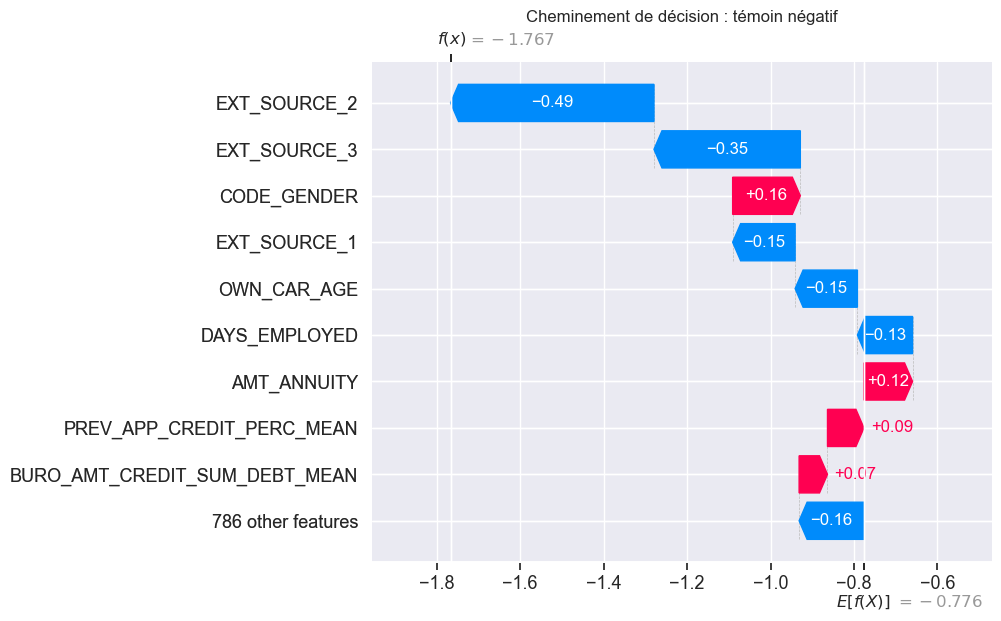

In [32]:
shap_plot_nonlinear(df_nonlinear, labels_nonlinear, params_nonlinear)

- **Explicabilité globale**
<br> Encore une fois, beaucoup de similarité entre ce résultat et celui de la partie linéaire. On voit ici trôner tout en haut de l'importance pour la prise de décision les notes associées aux individus, suivies par des critères comme le genre, la vitesse de repaiement du crédit ou encore le temps passé avec un emploi par exemple.
- **Explicabilité locale**
<br> Sans rentrer en détail sur les deux individus séparément, ils sont tous les deux poussés comme attendu dans une certaine direction par leurs notes principalement.

_Note : Pour permettre une comparaison plus fine avec le modèle linéaire, les individus décrits ici dans la partie "LOCALE" sont les mêmes._

### Recherche du seuil idéal

In [33]:
def seuil_optimal_nonlinear(X, y, params):
    model = LGBMClassifier(**params,
                            objective='binary',
                            is_unbalance=True,
                            random_state=0,
                            verbose=0,
                            force_col_wise=True)
    # prédiction
    y_pred = model.fit(X, y).predict_proba(X)[:,1]
    # calcul
    best_cost = float('inf')
    cost_list=[]
    pic_name = 'pics/non_linear/cost_fct_threshold_nonlinear.png'
    for seuil in np.arange(0,1.01,0.01):
        pred = pd.Series(np.where(y_pred >= seuil, 1, 0)) # création d'un vecteur d'attribution de classe en fonction du seuil et du vecteur 
        tmp = pd.concat([y.reset_index(drop=True),pred], ignore_index=True, axis=1)
        fp = tmp.loc[tmp[0]==0].loc[tmp[1]==1] # comptage False Positives
        fn = tmp.loc[tmp[0]==1].loc[tmp[1]==0] # comptage False Negatives
        cost = 1*len(fp) + 10*len(fn) # fonction coût
        cost_list.append(cost)
        if cost <= best_cost:
            best_cost = cost
            best_seuil = seuil
        
    print(f"Le coût le plus bas est {best_cost} (coût unitaire symbolique) et il est atteint pour un seuil à {best_seuil}")
    # plot
    plt.figure(figsize=(8,8))
    sns.lineplot(x=np.arange(0,1.01,0.01), y=cost_list)
    plt.xlabel('Valeur de seuil')
    plt.ylabel('Coût')
    plt.title("Evolution du coût en fonction du seuil d'appartenance à la classe 1")
    plt.tight_layout()
    plt.savefig(pic_name)
    plt.show()

De la même manière que pour la classification linéaire, on va rechercher ici le seuil optimal d'attribution de classe du modèle non linéaire.

Le coût le plus bas est 135061 (coût unitaire symbolique) et il est atteint pour un seuil à 0.52


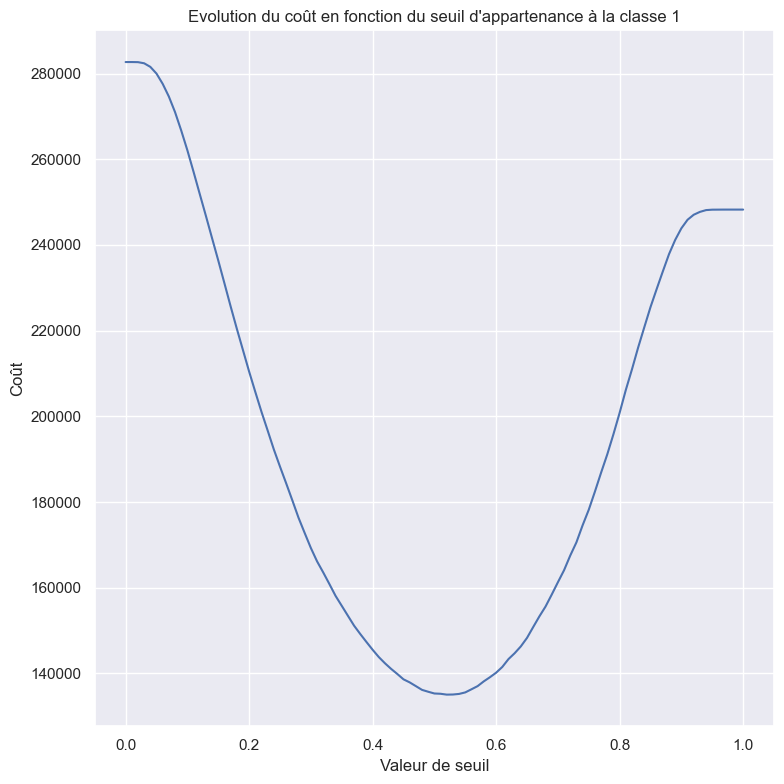

In [34]:
seuil_optimal_nonlinear(df_nonlinear, labels_nonlinear, params_nonlinear)

Le seuil optimal d'attribution de classe lié au modèle non linéaire est 0.52.

_Note : la différence d'échelle en ordonnée entre les deux graphiques de recherche du seuil est dûe au fait que le premier graphique calcule le coût sur un échantillon de 10k individus tandis que le second le fait pour un échantillon de 300k individus_

# 4. Déploiement du modèle

## 4.1 Création du pipeline de prédiction

In [35]:
def pipeline_creation(classifier,X,y):
    with timer("Temps de création du pipeline:"):
        # pipeline
        pipeline = Pipeline([
            ('classifier', classifier)
        ])
        # fit
        pipeline.fit(X,y)
        # scoring
        print(f"Score du pipeline : {pipeline.score(X,y)}")
        return pipeline

_Note : je ne réalise pas de train/test lors de la création du pipeline de prédiction car je connais déjà les performances des paramètres que je choisis. Je réalise tout de même un scoring sur l'entièreté des données pour m'assurer que le fitting s'est bien déroulé._

In [36]:
classifier = LGBMClassifier(**params_nonlinear,
                            objective='binary',
                            is_unbalance=True,
                            random_state=0,
                            verbose=0,
                            force_col_wise=True)
pipeline = pipeline_creation(classifier,df_nonlinear,labels_nonlinear)

Score du pipeline : 0.7316971646173909
Temps de création du pipeline: 26.26 s


In [37]:
joblib.dump(pipeline, 'pipeline_p7.joblib')

['pipeline_p7.joblib']